In [1]:
import sys
%tensorflow_version 1.x
!pip install config
!git clone https://github.com/NVlabs/stylegan2
import tensorflow as tf
sys.path.insert(0, "/content/stylegan2")
print(sys.path)
import dnnlib
import dnnlib.tflib as tflib
import pickle
import matplotlib.pyplot as plt
import numpy as np

TensorFlow 1.x selected.
Cloning into 'stylegan2'...
remote: Enumerating objects: 127, done.
remote: Total 127 (delta 0), reused 0 (delta 0), pack-reused 127
Receiving objects: 100% (127/127), 591.89 KiB | 8.11 MiB/s, done.
Resolving deltas: 100% (58/58), done.
['/content/stylegan2', '/tensorflow-1.15.2/python3.7', '', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython']


In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
tflib.init_tf()
path = "/content/drive/MyDrive/stylegan2-ffhq-config-e.pkl"
f=open(path,'rb')
_G, _D, Gs=pickle.load(f)
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [4]:
class generator:
  def __init__(self,n,imgs,latentz,k):
    self.n=n
    self.imgs=imgs
    self.latentz=[]
    self.k=k
    
  def generate(self):
    for i in range(self.n):

      #SAME LATENT SPACE CONTROL BASED ON PARAMETERS OF np.random.RandomState()
      rnd = np.random.RandomState(self.k)
      self.latentz.append(rnd.randn(1, Gs.input_shape[1]))
      #RANDOM IMAGE GENERatION WITH RANDOM LATENT SPACE
      # z_sample =random.rand(1,Gs.input_shape[1])
      # self.latentz.append(np.asmatrix(np.array([z_sample])))
      (self.imgs).append(np.squeeze( (Gs.run(self.latentz[i], None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)), axis=0))
      self.k=self.k+1

In [42]:
from numpy import random
imgs=[]  
latentz=[]
number_imgs=3
imgtest=generator(number_imgs,imgs, latentz,3)
imgtest.generate()



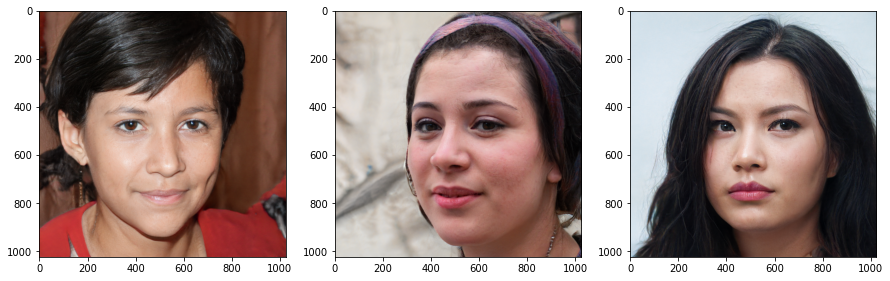

In [43]:
plt.figure(figsize=(15,15))
for i,img in enumerate(imgtest.imgs):
      plt.subplot(1,3,i+1)
      plt.imshow(img)
      

In [44]:

Gs.print_layers()


Gs                              Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/latents_in            -         (?, 512)             -               
G_mapping/labels_in             -         (?, 0)               -               
G_mapping/Normalize             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping/Dense1                262656    (?, 512)             (512, 512)      
G_mapping/Dense2                262656    (?, 512)             (512, 512)      
G_mapping/Dense3                262656 

In [45]:
src_dlatents=[]
for i in range(number_imgs):
  src_latents=imgtest.latentz[i]
  src_dlatents.append(Gs.components.mapping.run(src_latents, None))

In [46]:
#this is the concatenation of the mappings of the latent space
#which acts as the intermediate latent code W
#This space is used for the embedding
print(src_dlatents[0].shape)

(1, 18, 512)


In [127]:
src_dlatents1=[]
src_dlatents2=[]
smile=np.load('/content/smile.npy')
for i in range(number_imgs):
  src_dlatents1.append(src_dlatents[i]-smile*8)
  src_dlatents2.append(src_dlatents[i]+smile*8)

In [128]:
manip1=[]
manip2=[]
for i in range(number_imgs):
  manip1.append(Gs.components.synthesis.run(src_dlatents1[i], randomize_noise=False, output_transform=fmt))
  manip2.append(Gs.components.synthesis.run(src_dlatents2[i], randomize_noise=False, output_transform=fmt))

In [129]:
print(manip1[2].shape)

(1, 1024, 1024, 3)


In [130]:
for i in range(number_imgs):
  manip1[i]=np.squeeze(manip1[i],axis=0)
  manip2[i]=np.squeeze(manip2[i],axis=0)

In [131]:
test=[]
for i in range(number_imgs):
  test.append(imgtest.imgs[i])
  test.append(manip1[i])
  test.append(manip2[i])

titles=["original","smile+", "smile-"]*number_imgs

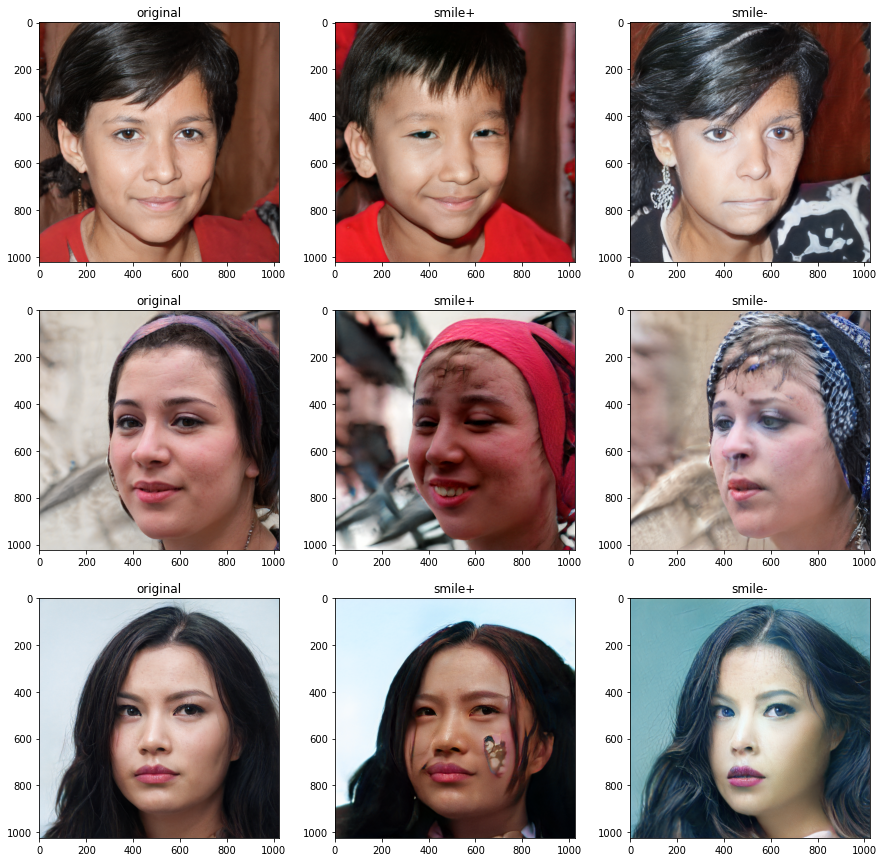

In [132]:
plt.figure(figsize=(15,15))
for i,img in enumerate(test):
      plt.subplot(3,3,i+1)
      plt.imshow(img)
      plt.title(titles[i])
    

In [144]:
import IPython.display
import time
from PIL import Image

def lat_to_img(x):
  img=np.squeeze((Gs.components.synthesis.run(x, randomize_noise=False, output_transform=fmt)), axis=0)
  return img

def expression(w1,w2,w3):
  k=0
  imgset=[]
  while k<=1:
    w=w1+k*(w3-w2)
    img=np.squeeze(Gs.components.synthesis.run(w, randomize_noise=False, output_transform=fmt), axis=0)
    imgset.append(img)
    IPython.display.clear_output(wait=True)
    IPython.display.display_png(Image.fromarray(img))
    k=k+0.1
    time.sleep(1.5)
  return imgset




In [145]:
womanimg=[] 
lat1=[]
woman=generator(1,womanimg,lat1,12)
woman.generate()
wom_latents=woman.latentz[0]
wom_dlatents = Gs.components.mapping.run(wom_latents, None)
wom_happyl=wom_dlatents + smile*14
wom_sadl= wom_dlatents - smile*10
wom_happy=lat_to_img(wom_happyl)
wom_sad=lat_to_img(wom_sadl)

In [146]:
# test=[]
test=[wom_sad,woman.imgs[0],wom_happy]
titles=["Happy", "Normal", "Sad/Angry"]

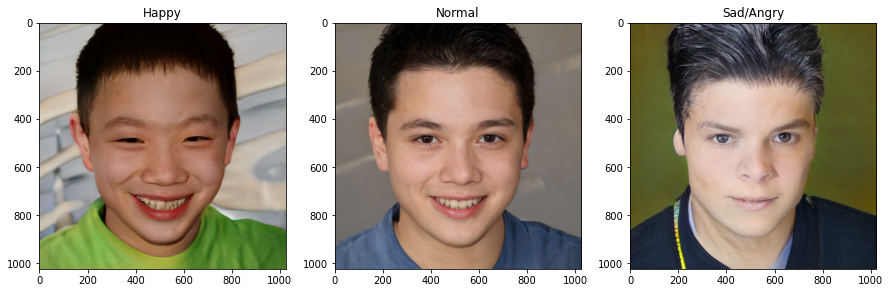

In [147]:
plt.figure(figsize=(15,15))
for i,img in enumerate(test):
      plt.subplot(1,3,i+1)
      plt.imshow(img)
      plt.title(titles[i])
    

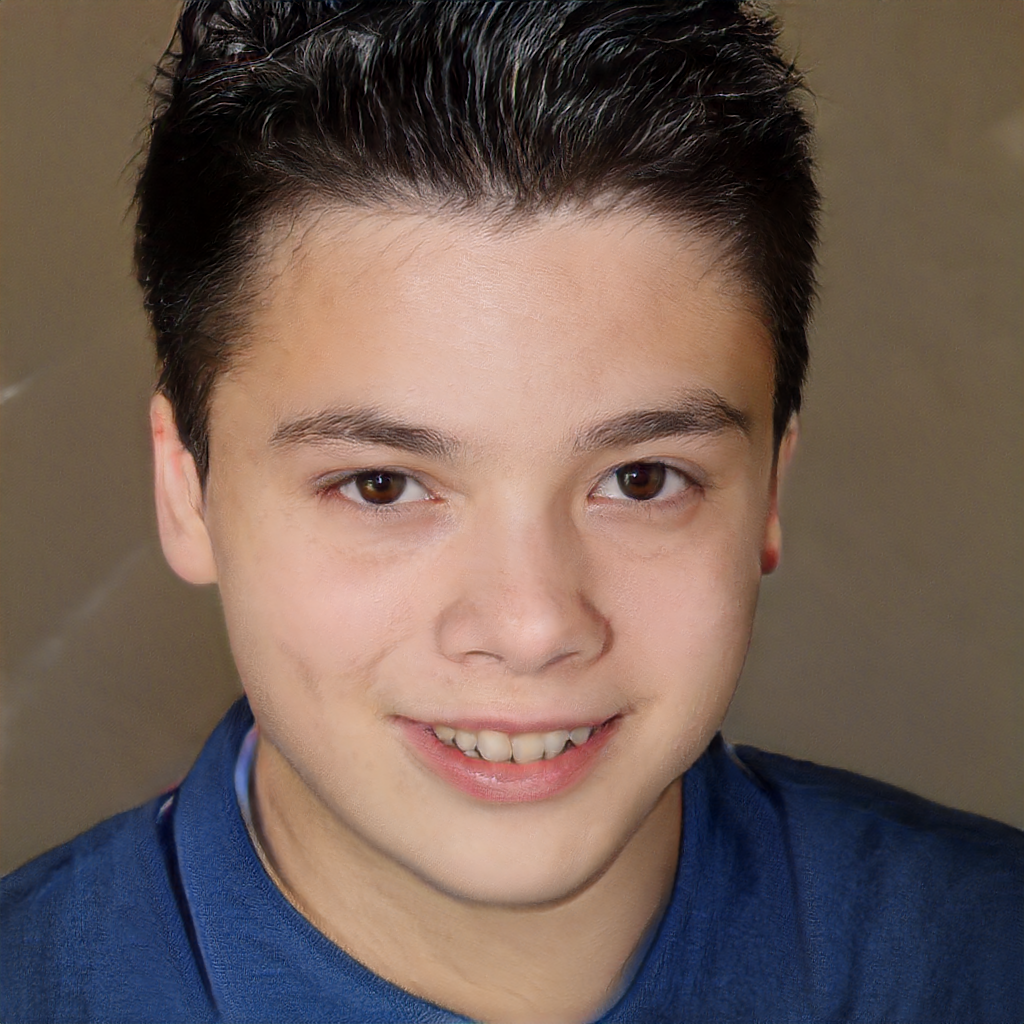

In [148]:
imgset=expression(wom_happyl, wom_dlatents, wom_sadl)

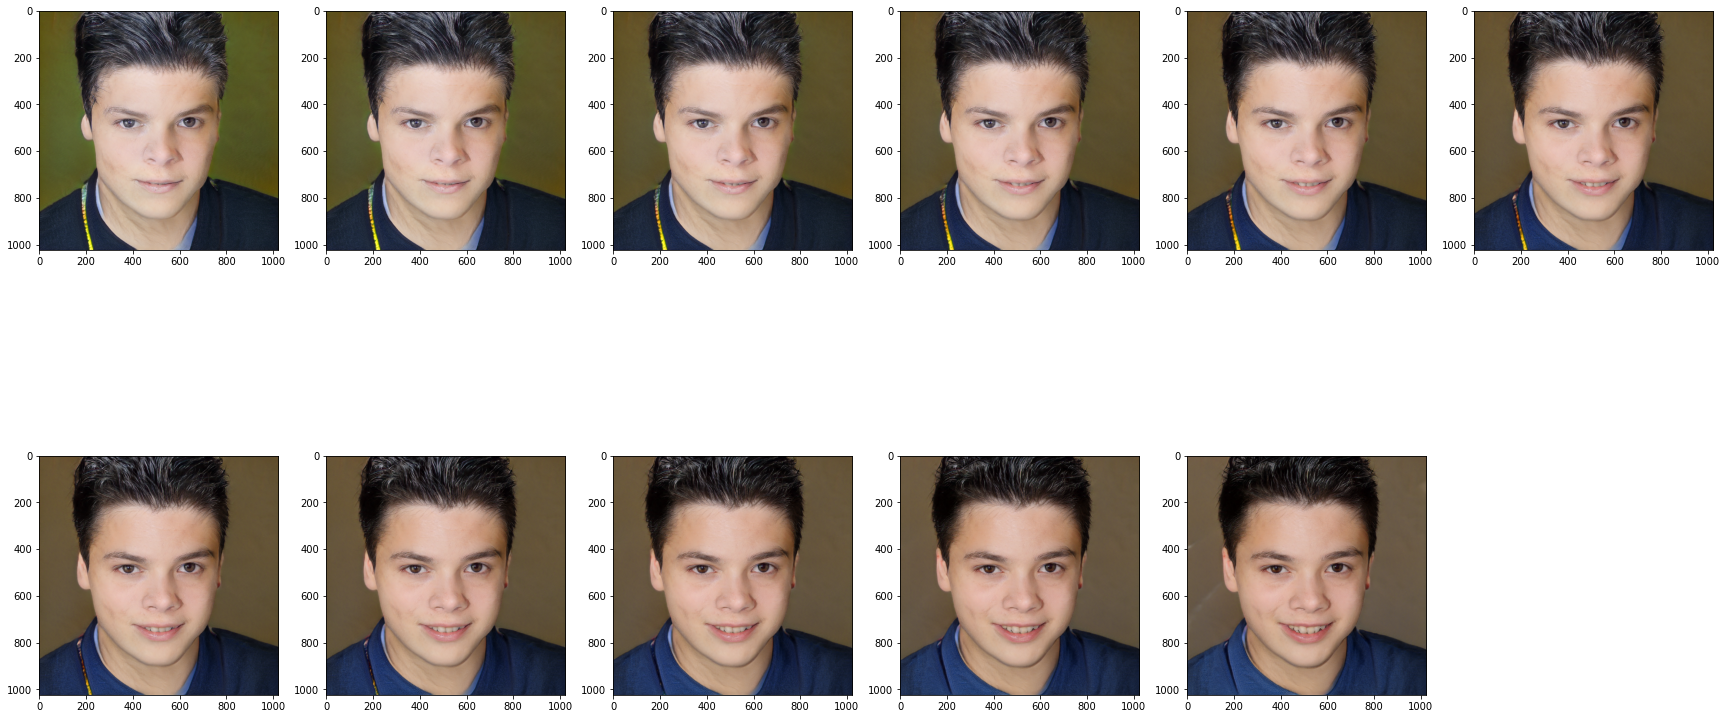

In [149]:
plt.figure(figsize=(30,15))
for i,img in enumerate(imgset):
      plt.subplot(2,6,i+1)
      plt.imshow(img)
    

In [ ]:
#DATASET FOR IMAGE IMAGE PIPELINE MODEL TRAINING
# dataset_imgs=[]  
# dataset_latentz=[]
# number_dataset=100
# dataset=generator(number_dataset,dataset_imgs, dataset_latentz,8)
# dataset.generate()


In [ ]:
# print(dataset.imgs[0]

In [ ]:
# def latent_to_image(dataset):




# dataset_imgs=[]  
# dataset_latentz=[]
# number_dataset=5
# dataset=generator(number_dataset,dataset_imgs, dataset_latentz,8)
# dataset.generate()

# l=len(dataset.imgs)
# print(l)

# datasetfinal2=[]


# for i in range(l):
#   datasetfinal=[]
#   lat=dataset.latentz[i]
#   dlatents = Gs.components.mapping.run(lat, None)
#   dlatents_male = dlatents + gender*14
#   dlatents_female = dlatents -gender*14
#   dlatents_old = dlatents + age*14
#   dlatents_young = dlatents - age*14
#   img=lat_to_img(dlatents)
#   img_male=lat_to_img(dlatents_male)                    
#   img_female=lat_to_img(dlatents_female)
#   img_old=lat_to_img(dlatents_old)
#   img_young=lat_to_img(dlatents_young)
#   datasetfinal.append(img)
#   datasetfinal.append(img_male)
#   datasetfinal.append(img_female)
#   datasetfinal.append(img_old)
#   datasetfinal.append(img_young)
#   datasetfinal2.append(datasetfinal)

5


5


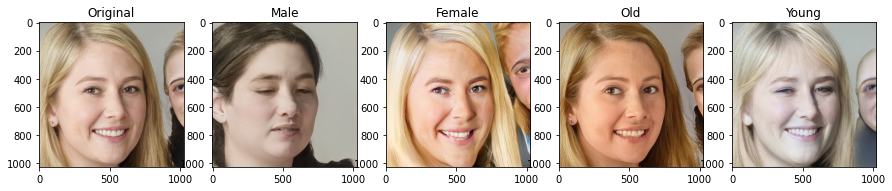

In [ ]:
# plt.figure(figsize=(15,15))
# print(len(datasetfinal2[0]))
# titles=['Original','Male','Female','Old','Young']
# for i,img in enumerate(datasetfinal2[2]):
#       plt.subplot(1,5,i+1)
#       plt.imshow(img)
#       plt.title(titles[i])
      

In [ ]:
#DATASET FOR IMAGE IMAGE PIPELINE MODEL TRAINING
dataset_imgs=[]  
dataset_latentz=[]
number_dataset=700
dataset=generator(number_dataset,dataset_imgs, dataset_latentz,8)
dataset.generate()

l=len(dataset.imgs)
print(l)






1000


In [ ]:
datasetfinal2=[]


for i in range(l):
  datasetfinal=[]
  lat=dataset.latentz[i]
  dlatents = Gs.components.mapping.run(lat, None)
  dlatents_female = dlatents -gender*14
  img=lat_to_img(dlatents)                   
  img_female=lat_to_img(dlatents_female)
  datasetfinal.append(img)
  datasetfinal.append(img_female)
  datasetfinal2.append(datasetfinal)

In [ ]:
import pickle

with open("file.pkl", 'wb') as f:
  # indent=2 is not needed but makes the file human-readable
  pickle.dump(datasetfinal2, f) 
